In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..\\..'))
	print(os.getcwd())
except:
	pass


In [1]:

#pylint: disable=no-name-in-module
from tensorflow import keras
import os
import numpy as np
import pandas as pd




In [2]:
#dframe=pd.read_pickle('./AMMfull.pkl')
dframe=pd.read_csv("Monterrey/data/imputed/data/NOROESTE.csv", 
    parse_dates=["FECHA"], infer_datetime_format=True).set_index("FECHA")

In [3]:
#dframe.mean(axis=0).unstack('ESTACION')
#df2=dframe['NOROESTE'].fillna(method='ffill').as_matrix()
df2=dframe.values
#Max normalization
df2=df2/np.nanmax(df2)

In [4]:
# concentration in a delay.
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            #Here my targets could be O3(4),PM10(5),PM2.5(6)
            targets[j] = data[rows[j] + delay][5]
        yield samples, targets

In [5]:
lookback = 72
step = 1
delay = 24
batch_size = 128

train_gen = generator(df2,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=35000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(df2,
                    lookback=lookback,
                    delay=delay,
                    min_index=35001,
                    max_index=40000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(df2,
                     lookback=lookback,
                     delay=delay,
                     min_index=40001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)


In [6]:

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (40000 - 35001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(df2) - 40001 - lookback) // batch_size


In [7]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()


0.061107793651198596


In [8]:
#pylint: disable=import-error
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, df2.shape[-1])))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae', metrics=['mae', 'acc'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=1,
                              epochs=32,
                              validation_data=val_gen,
                              validation_steps=val_steps)


Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use tf.cast instead.


Epoch 1/32


1/1 [==============================] - 4s 4s/step - loss: 0.3168 - mean_absolute_error: 0.3168 - acc: 0.0000e+00 - val_loss: 0.0291 - val_mean_absolute_error: 0.0291 - val_acc: 0.0000e+00


Epoch 2/32
1/1 [==============================] - 0s 199ms/step - loss: 0.0359 - mean_absolute_error: 0.0359 - acc: 0.0000e+00 - val_loss: 0.0455 - val_mean_absolute_error: 0.0455 - val_acc: 0.0000e+00


Epoch 3/32
1/1 [==============================] - 0s 195ms/step - loss: 0.0510 - mean_absolute_error: 0.0510 - acc: 0.0000e+00 - val_loss: 0.2574 - val_mean_absolute_error: 0.2574 - val_acc: 0.0000e+00


Epoch 4/32
1/1 [==============================] - 0s 193ms/step - loss: 0.2566 - mean_absolute_error: 0.2566 - acc: 0.0000e+00 - val_loss: 0.0747 - val_mean_absolute_error: 0.0747 - val_acc: 0.0000e+00


Epoch 5/32
1/1 [==============================] - 0s 195ms/step - loss: 0.0799 - mean_absolute_error: 0.0799 - acc: 0.0000e+00 - val_loss: 0.1140 - val_mean_absolute_error: 0.1140 - val_acc: 0.0000e+00


Epoch 6/32
1/1 [==============================] - 0s 195ms/step - loss: 0.1101 - mean_absolute_error: 0.1101 - acc: 0.0000e+00 - val_loss: 0.0274 - val_mean_absolute_error: 0.0274 - val_acc: 0.0000e+00


Epoch 7/32
1/1 [==============================] - 0s 198ms/step - loss: 0.0310 - mean_absolute_error: 0.0310 - acc: 0.0000e+00 - val_loss: 0.0368 - val_mean_absolute_error: 0.0368 - val_acc: 0.0000e+00


Epoch 8/32


1/1 [==============================] - 0s 196ms/step - loss: 0.0407 - mean_absolute_error: 0.0407 - acc: 0.0000e+00 - val_loss: 0.0391 - val_mean_absolute_error: 0.0391 - val_acc: 0.0000e+00


Epoch 9/32
1/1 [==============================] - 0s 196ms/step - loss: 0.0423 - mean_absolute_error: 0.0423 - acc: 0.0000e+00 - val_loss: 0.0598 - val_mean_absolute_error: 0.0598 - val_acc: 0.0000e+00


Epoch 10/32
1/1 [==============================] - 0s 197ms/step - loss: 0.0614 - mean_absolute_error: 0.0614 - acc: 0.0000e+00 - val_loss: 0.0325 - val_mean_absolute_error: 0.0325 - val_acc: 0.0000e+00


Epoch 11/32
1/1 [==============================] - 0s 193ms/step - loss: 0.0397 - mean_absolute_error: 0.0397 - acc: 0.0000e+00 - val_loss: 0.0585 - val_mean_absolute_error: 0.0585 - val_acc: 0.0000e+00


Epoch 12/32
1/1 [==============================] - 0s 197ms/step - loss: 0.0594 - mean_absolute_error: 0.0594 - acc: 0.0000e+00 - val_loss: 0.0458 - val_mean_absolute_error: 0.0458 - val_acc: 0.0000e+00


Epoch 13/32


1/1 [==============================] - 0s 199ms/step - loss: 0.0539 - mean_absolute_error: 0.0539 - acc: 0.0000e+00 - val_loss: 0.0379 - val_mean_absolute_error: 0.0379 - val_acc: 0.0000e+00


Epoch 14/32
1/1 [==============================] - 0s 194ms/step - loss: 0.0407 - mean_absolute_error: 0.0407 - acc: 0.0000e+00 - val_loss: 0.0263 - val_mean_absolute_error: 0.0263 - val_acc: 0.0000e+00


Epoch 15/32
1/1 [==============================] - 0s 197ms/step - loss: 0.0399 - mean_absolute_error: 0.0399 - acc: 0.0000e+00 - val_loss: 0.0319 - val_mean_absolute_error: 0.0319 - val_acc: 0.0000e+00


Epoch 16/32
1/1 [==============================] - 0s 195ms/step - loss: 0.0392 - mean_absolute_error: 0.0392 - acc: 0.0000e+00 - val_loss: 0.0452 - val_mean_absolute_error: 0.0452 - val_acc: 0.0000e+00


Epoch 17/32


1/1 [==============================] - 0s 196ms/step - loss: 0.0553 - mean_absolute_error: 0.0553 - acc: 0.0000e+00 - val_loss: 0.0536 - val_mean_absolute_error: 0.0536 - val_acc: 0.0000e+00


Epoch 18/32


1/1 [==============================] - 0s 203ms/step - loss: 0.0556 - mean_absolute_error: 0.0556 - acc: 0.0000e+00 - val_loss: 0.0298 - val_mean_absolute_error: 0.0298 - val_acc: 0.0000e+00


Epoch 19/32


1/1 [==============================] - 0s 194ms/step - loss: 0.0378 - mean_absolute_error: 0.0378 - acc: 0.0000e+00 - val_loss: 0.0412 - val_mean_absolute_error: 0.0412 - val_acc: 0.0000e+00


Epoch 20/32


1/1 [==============================] - 0s 195ms/step - loss: 0.0455 - mean_absolute_error: 0.0455 - acc: 0.0000e+00 - val_loss: 0.0353 - val_mean_absolute_error: 0.0353 - val_acc: 0.0000e+00


Epoch 21/32


1/1 [==============================] - 0s 196ms/step - loss: 0.0376 - mean_absolute_error: 0.0376 - acc: 0.0000e+00 - val_loss: 0.0421 - val_mean_absolute_error: 0.0421 - val_acc: 0.0000e+00


Epoch 22/32
1/1 [==============================] - 0s 198ms/step - loss: 0.0441 - mean_absolute_error: 0.0441 - acc: 0.0000e+00 - val_loss: 0.0371 - val_mean_absolute_error: 0.0371 - val_acc: 0.0000e+00


Epoch 23/32


1/1 [==============================] - 0s 195ms/step - loss: 0.0446 - mean_absolute_error: 0.0446 - acc: 0.0000e+00 - val_loss: 0.0414 - val_mean_absolute_error: 0.0414 - val_acc: 0.0000e+00


Epoch 24/32


1/1 [==============================] - 0s 194ms/step - loss: 0.0455 - mean_absolute_error: 0.0455 - acc: 0.0000e+00 - val_loss: 0.0319 - val_mean_absolute_error: 0.0319 - val_acc: 0.0000e+00


Epoch 25/32
1/1 [==============================] - 0s 195ms/step - loss: 0.0379 - mean_absolute_error: 0.0379 - acc: 0.0000e+00 - val_loss: 0.0322 - val_mean_absolute_error: 0.0322 - val_acc: 0.0000e+00


Epoch 26/32


1/1 [==============================] - 0s 205ms/step - loss: 0.0368 - mean_absolute_error: 0.0368 - acc: 0.0000e+00 - val_loss: 0.0285 - val_mean_absolute_error: 0.0285 - val_acc: 0.0000e+00


Epoch 27/32
1/1 [==============================] - 0s 196ms/step - loss: 0.0430 - mean_absolute_error: 0.0430 - acc: 0.0000e+00 - val_loss: 0.0316 - val_mean_absolute_error: 0.0316 - val_acc: 0.0000e+00


Epoch 28/32
1/1 [==============================] - 0s 196ms/step - loss: 0.0330 - mean_absolute_error: 0.0330 - acc: 0.0000e+00 - val_loss: 0.0346 - val_mean_absolute_error: 0.0346 - val_acc: 0.0000e+00


Epoch 29/32


1/1 [==============================] - 0s 197ms/step - loss: 0.0341 - mean_absolute_error: 0.0341 - acc: 0.0000e+00 - val_loss: 0.0293 - val_mean_absolute_error: 0.0293 - val_acc: 0.0000e+00


Epoch 30/32
1/1 [==============================] - 0s 195ms/step - loss: 0.0341 - mean_absolute_error: 0.0341 - acc: 0.0000e+00 - val_loss: 0.0317 - val_mean_absolute_error: 0.0317 - val_acc: 0.0000e+00


Epoch 31/32


1/1 [==============================] - 0s 201ms/step - loss: 0.0378 - mean_absolute_error: 0.0378 - acc: 0.0000e+00 - val_loss: 0.0325 - val_mean_absolute_error: 0.0325 - val_acc: 0.0000e+00


Epoch 32/32
1/1 [==============================] - 0s 201ms/step - loss: 0.0378 - mean_absolute_error: 0.0378 - acc: 0.0000e+00 - val_loss: 0.0350 - val_mean_absolute_error: 0.0350 - val_acc: 0.0000e+00


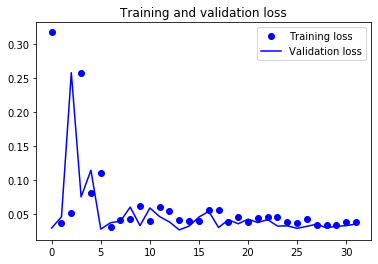

In [9]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [10]:
#pylint: disable=import-error
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, df2.shape[-1])))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae', metrics=['mae', 'acc'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=10,
                              epochs=32,
                              validation_data=val_gen,
                              validation_steps=val_steps)


Epoch 1/32
10/10 [==============================] - 1s 55ms/step - loss: 0.0955 - mean_absolute_error: 0.0955 - acc: 0.0000e+00 - val_loss: 0.0318 - val_mean_absolute_error: 0.0318 - val_acc: 0.0000e+00
Epoch 2/32
10/10 [==============================] - 0s 31ms/step - loss: 0.0356 - mean_absolute_error: 0.0356 - acc: 0.0000e+00 - val_loss: 0.0377 - val_mean_absolute_error: 0.0377 - val_acc: 0.0000e+00
Epoch 3/32
10/10 [==============================] - 0s 31ms/step - loss: 0.0401 - mean_absolute_error: 0.0401 - acc: 0.0000e+00 - val_loss: 0.0279 - val_mean_absolute_error: 0.0279 - val_acc: 0.0000e+00
Epoch 4/32
10/10 [==============================] - 0s 31ms/step - loss: 0.0338 - mean_absolute_error: 0.0338 - acc: 0.0000e+00 - val_loss: 0.0266 - val_mean_absolute_error: 0.0266 - val_acc: 0.0000e+00
Epoch 5/32
10/10 [==============================] - 0s 30ms/step - loss: 0.0390 - mean_absolute_error: 0.0390 - acc: 0.0000e+00 - val_loss: 0.0295 - val_mean_absolute_error: 0.0295 - val_a

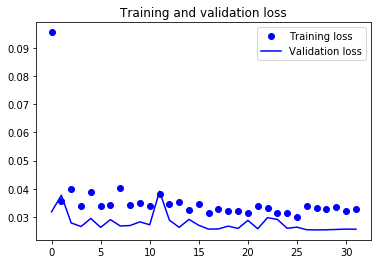

In [11]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [12]:
#pylint: disable=import-error
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, df2.shape[-1])))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae', metrics=['mae', 'acc'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=20,
                              epochs=32,
                              validation_data=val_gen,
                              validation_steps=val_steps)


Epoch 1/32
20/20 [==============================] - 1s 32ms/step - loss: 0.0629 - mean_absolute_error: 0.0629 - acc: 0.0000e+00 - val_loss: 0.0262 - val_mean_absolute_error: 0.0262 - val_acc: 0.0000e+00
Epoch 2/32
20/20 [==============================] - 0s 21ms/step - loss: 0.0396 - mean_absolute_error: 0.0396 - acc: 0.0000e+00 - val_loss: 0.0260 - val_mean_absolute_error: 0.0260 - val_acc: 0.0000e+00
Epoch 3/32
20/20 [==============================] - 0s 21ms/step - loss: 0.0392 - mean_absolute_error: 0.0392 - acc: 0.0000e+00 - val_loss: 0.0271 - val_mean_absolute_error: 0.0271 - val_acc: 0.0000e+00
Epoch 4/32
20/20 [==============================] - 0s 21ms/step - loss: 0.0343 - mean_absolute_error: 0.0343 - acc: 0.0000e+00 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280 - val_acc: 0.0000e+00
Epoch 5/32
20/20 [==============================] - 0s 20ms/step - loss: 0.0362 - mean_absolute_error: 0.0362 - acc: 0.0000e+00 - val_loss: 0.0261 - val_mean_absolute_error: 0.0261 - val_a

In [13]:
#pylint: disable=import-error
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, df2.shape[-1])))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae', metrics=['mae'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=20,
                              epochs=32,
                              validation_data=val_gen,
                              validation_steps=val_steps)


Epoch 1/32
20/20 [==============================] - 1s 31ms/step - loss: 0.0881 - mean_absolute_error: 0.0881 - val_loss: 0.0296 - val_mean_absolute_error: 0.0296
Epoch 2/32
20/20 [==============================] - 0s 21ms/step - loss: 0.0424 - mean_absolute_error: 0.0424 - val_loss: 0.0312 - val_mean_absolute_error: 0.0312
Epoch 3/32
20/20 [==============================] - 0s 19ms/step - loss: 0.0392 - mean_absolute_error: 0.0392 - val_loss: 0.0475 - val_mean_absolute_error: 0.0475
Epoch 4/32
20/20 [==============================] - 0s 20ms/step - loss: 0.0374 - mean_absolute_error: 0.0374 - val_loss: 0.0318 - val_mean_absolute_error: 0.0318
Epoch 5/32
20/20 [==============================] - 0s 19ms/step - loss: 0.0341 - mean_absolute_error: 0.0341 - val_loss: 0.0313 - val_mean_absolute_error: 0.0313
Epoch 6/32
20/20 [==============================] - 0s 20ms/step - loss: 0.0357 - mean_absolute_error: 0.0357 - val_loss: 0.0264 - val_mean_absolute_error: 0.0264
Epoch 7/32
20/20 [====

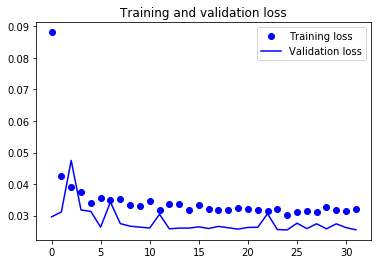

In [14]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [15]:
def data_generator(gen,steps):
    samp_imp = []
    samp_out = []
    for step in range(steps):
        samples, targets = next(gen)
        #preds = samples[:, -1, 1]
        #mae = np.mean(np.abs(preds - targets))
        #batch_maes.append(mae)
        samp_imp.append(samples)
        samp_out.append(targets)
    #print(np.mean(batch_maes))
    return samp_imp, samp_out

samp_imp, samp_out= data_generator(val_gen, val_steps)


In [16]:
type(samp_imp)

list

In [17]:
np.array(samp_imp).shape

(38, 128, 72, 15)

In [18]:
np.array(samp_imp).len

AttributeError: 'numpy.ndarray' object has no attribute 'len'

In [19]:
np.array(samp_imp).len()

AttributeError: 'numpy.ndarray' object has no attribute 'len'

In [20]:
len(np.array(samp_imp))

38

In [21]:
def data_generator(gen,steps):
    samp_imp = []
    samp_out = []
    for step in range(steps):
        samples, targets = next(gen)
        #preds = samples[:, -1, 1]
        #mae = np.mean(np.abs(preds - targets))
        #batch_maes.append(mae)
        samp_imp.extend(samples)
        samp_out.extend(targets)
    #print(np.mean(batch_maes))
    return samp_imp, samp_out

samp_imp, samp_out= data_generator(val_gen, val_steps)


In [22]:
np.array(samp_imp).shape

(4864, 72, 15)

In [23]:
lookback//step

72

In [24]:
np.array(samp_out).shape

(4864,)

In [25]:
np.array(samp_out)[1]

0.044

In [26]:
np.array(samp_out)[3]

0.042

In [27]:
type(model)

keras.engine.sequential.Sequential

In [28]:
np.array(samp_imp)[0,:,:]

array([[0.00128   , 0.00826402, 0.01982791, ..., 0.02272   , 0.108     ,
        0.0105    ],
       [0.00109   , 0.0079693 , 0.03565388, ..., 0.02138   , 0.086     ,
        0.0094    ],
       [0.00213   , 0.01      , 0.0158    , ..., 0.0201    , 0.172     ,
        0.0031    ],
       ...,
       [0.00061   , 0.00790029, 0.00823631, ..., 0.02048   , 0.207     ,
        0.0048    ],
       [0.00069   , 0.00762418, 0.00853446, ..., 0.02066   , 0.152     ,
        0.0063    ],
       [0.0006    , 0.00763092, 0.00775455, ..., 0.02036   , 0.088     ,
        0.0087    ]])

In [30]:
np.array(samp_imp)[0,:,:].shape

(72, 15)

In [31]:
model.predict(np.array(samp_imp)[0,:,:])

ValueError: Error when checking input: expected flatten_4_input to have 3 dimensions, but got array with shape (72, 15)

In [32]:
model.predict(np.array(samp_imp[0,:,:])[,:,:])

SyntaxError: invalid syntax (<ipython-input-32-fc7ac2df0557>, line 1)

In [33]:
model.predict(np.array(samp_imp[0,:,:])[:,:,:])

TypeError: list indices must be integers or slices, not tuple

In [34]:
pred_test=model.predict(np.array(samp_imp))

In [35]:
pred_test.shape

(4864, 1)

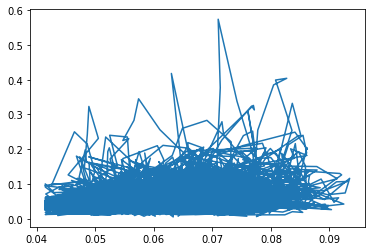

In [36]:
plt.plot(pred_test, samp_out)

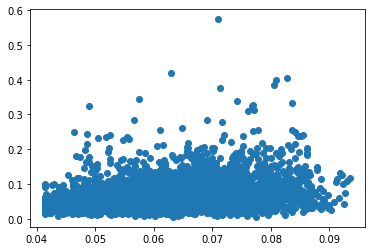

In [37]:
plt.plot(pred_test, samp_out,'o')

In [38]:
np.mean(np.abs(pred_test-samp_out))

0.027768483561390188

In [39]:
from sklearn import metrics
det_coeff= metrics.r2_score(samp_out,pred_test)
print(pred_test)

[[0.07538974]
 [0.07210812]
 [0.06924085]
 ...
 [0.07947406]
 [0.07980732]
 [0.0777062 ]]


In [40]:
from sklearn import metrics
det_coeff= metrics.r2_score(samp_out,pred_test)
print(det_coeff)

0.04364229294285571


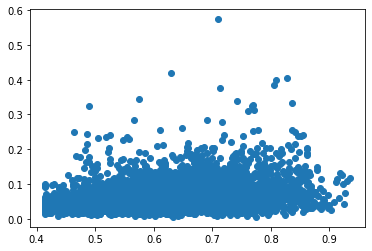

In [41]:
plt.plot(pred_test*10, samp_out,'o')

In [42]:
#pylint: disable=import-error
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, df2.shape[-1])))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mean_squared_error', metrics=['mean_squared_error'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=20,
                              epochs=32,
                              validation_data=val_gen,
                              validation_steps=val_steps)


Epoch 1/32
20/20 [==============================] - 1s 41ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 2/32
20/20 [==============================] - 0s 22ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 3/32
20/20 [==============================] - 0s 22ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 4/32
20/20 [==============================] - 0s 23ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 5/32
20/20 [==============================] - 0s 22ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 6/32
20/20 [==============================] - 0s 23ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 7/32
20/20 [================

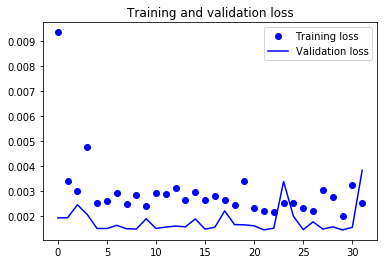

In [43]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [44]:
def data_from_generator(gen,steps):
    samp_imp = []
    samp_out = []
    for step in range(steps):
        samples, targets = next(gen)
        #preds = samples[:, -1, 1]
        #mae = np.mean(np.abs(preds - targets))
        #batch_maes.append(mae)
        samp_imp.extend(samples)
        samp_out.extend(targets)
    #print(np.mean(batch_maes))
    return samp_imp, samp_out

samp_imp, samp_out= data_from_generator(val_gen, val_steps)


In [45]:

test_results=model.evaluate_generator(test_gen, steps=1)
pred_test=model.predict(np.array(samp_imp))


In [46]:
from sklearn import metrics
det_coeff= metrics.r2_score(samp_out,pred_test)
print(det_coeff)

-1.4825016646383817


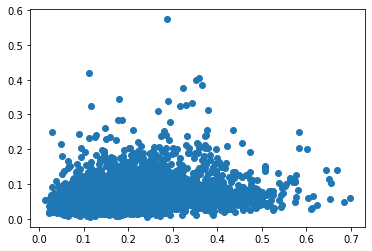

In [47]:
plt.plot(pred_test*10, samp_out,'o')

In [48]:
from sklearn import metrics
det_coeff= metrics.r2_score(samp_out,pred_test)
print(det_coeff)

-1.4825016646383817


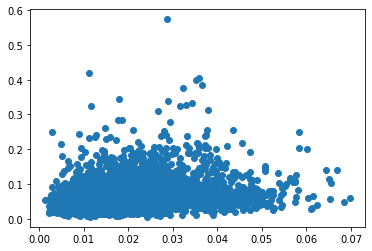

In [49]:

test_results=model.evaluate_generator(test_gen, steps=1)
pred_test=model.predict(np.array(samp_imp))
plt.plot(pred_test, samp_out,'o')

In [50]:
from sklearn import metrics
det_coeff= metrics.r2_score(samp_out,pred_test)
print(det_coeff)

-1.4825016646383817


In [51]:
from sklearn import metrics
det_coeff= metrics.r2_score(samp_out,pred_test*10)
print(det_coeff)

-15.680196863425582


In [52]:
from sklearn import metrics
det_coeff= metrics.r2_score(samp_out,pred_test)
print(det_coeff)

-1.4825016646383817


In [53]:
#pylint: disable=import-error
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, df2.shape[-1])))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mean_squared_error', metrics=['mean_squared_error'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=20,
                              epochs=100,
                              validation_data=val_gen,
                              validation_steps=val_steps)


Epoch 1/100
20/20 [==============================] - 1s 40ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 2/100
20/20 [==============================] - 0s 21ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 3/100
20/20 [==============================] - 0s 22ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 4/100
20/20 [==============================] - 0s 24ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 5/100
20/20 [==============================] - 0s 22ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 6/100
20/20 [==============================] - 0s 21ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 7/100
20/20 [=========

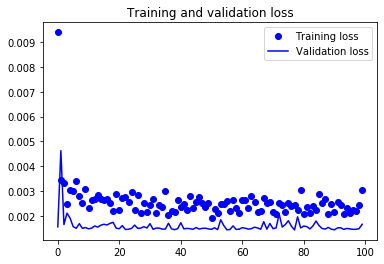

In [54]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [55]:
def data_from_generator(gen,steps):
    samp_imp = []
    samp_out = []
    for step in range(steps):
        samples, targets = next(gen)
        #preds = samples[:, -1, 1]
        #mae = np.mean(np.abs(preds - targets))
        #batch_maes.append(mae)
        samp_imp.extend(samples)
        samp_out.extend(targets)
    #print(np.mean(batch_maes))
    return samp_imp, samp_out

samp_imp, samp_out= data_from_generator(val_gen, val_steps)


In [56]:

model=keras.models.load_model("modelANN_imputed_May30.h5")



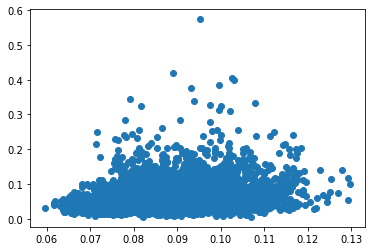

In [57]:

test_results=model.evaluate_generator(test_gen, steps=1)
pred_test=model.predict(np.array(samp_imp))
plt.plot(pred_test, samp_out,'o')

In [58]:
#pylint: disable=import-error
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, df2.shape[-1])))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mean_squared_error', metrics=['mean_squared_error'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=20,
                              epochs=50,
                              validation_data=val_gen,
                              validation_steps=val_steps)


Epoch 1/50
20/20 [==============================] - 1s 44ms/step - loss: 0.0166 - mean_squared_error: 0.0166 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 2/50
20/20 [==============================] - 0s 22ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 3/50
20/20 [==============================] - 0s 25ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 4/50
20/20 [==============================] - 0s 22ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 5/50
20/20 [==============================] - 0s 22ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 6/50
20/20 [==============================] - 0s 22ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 7/50
20/20 [================

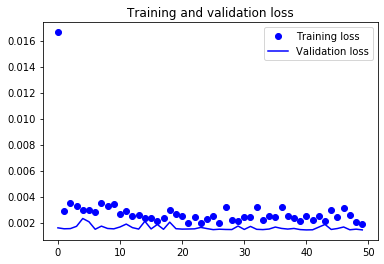

In [59]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [60]:
def data_from_generator(gen,steps):
    samp_imp = []
    samp_out = []
    for step in range(steps):
        samples, targets = next(gen)
        #preds = samples[:, -1, 1]
        #mae = np.mean(np.abs(preds - targets))
        #batch_maes.append(mae)
        samp_imp.extend(samples)
        samp_out.extend(targets)
    #print(np.mean(batch_maes))
    return samp_imp, samp_out

samp_imp, samp_out= data_from_generator(val_gen, val_steps)


In [61]:

#model=keras.models.load_model("modelANN_imputed_May30.h5")



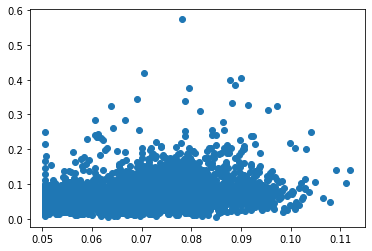

In [62]:

test_results=model.evaluate_generator(test_gen, steps=1)
pred_test=model.predict(np.array(samp_imp))
plt.plot(pred_test, samp_out,'o')

In [63]:
from sklearn import metrics
det_coeff= metrics.r2_score(samp_out,pred_test)
print(det_coeff)

0.069700782428469


In [64]:
def data_from_generator(gen,steps):
    samp_imp = []
    samp_out = []
    for step in range(steps):
        samples, targets = next(gen)
        #preds = samples[:, -1, 1]
        #mae = np.mean(np.abs(preds - targets))
        #batch_maes.append(mae)
        samp_imp.extend(samples)
        samp_out.extend(targets)
    #print(np.mean(batch_maes))
    return samp_imp, samp_out

samp_imp, samp_out= data_from_generator(test_gen, test_steps)


In [65]:

#model=keras.models.load_model("modelANN_imputed_May30.h5")



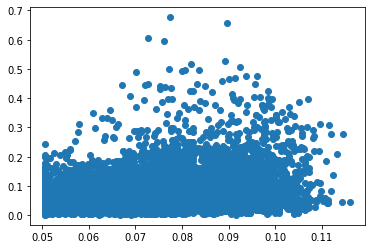

In [66]:

test_results=model.evaluate_generator(test_gen, steps=1)
pred_test=model.predict(np.array(samp_imp))
plt.plot(pred_test, samp_out,'o')

In [67]:
from sklearn import metrics
det_coeff= metrics.r2_score(samp_out,pred_test)
print(det_coeff)

0.12592589565061896


In [68]:
#pylint: disable=import-error
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, df2.shape[-1])))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae', metrics=['mean_squared_error'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=20,
                              epochs=50,
                              validation_data=val_gen,
                              validation_steps=val_steps)


Epoch 1/50
20/20 [==============================] - 1s 44ms/step - loss: 0.0964 - mean_squared_error: 0.0273 - val_loss: 0.0360 - val_mean_squared_error: 0.0026
Epoch 2/50
20/20 [==============================] - 0s 22ms/step - loss: 0.0401 - mean_squared_error: 0.0033 - val_loss: 0.0332 - val_mean_squared_error: 0.0024
Epoch 3/50
20/20 [==============================] - 0s 22ms/step - loss: 0.0403 - mean_squared_error: 0.0035 - val_loss: 0.0273 - val_mean_squared_error: 0.0018
Epoch 4/50
20/20 [==============================] - 0s 22ms/step - loss: 0.0357 - mean_squared_error: 0.0027 - val_loss: 0.0358 - val_mean_squared_error: 0.0020
Epoch 5/50
20/20 [==============================] - 0s 22ms/step - loss: 0.0387 - mean_squared_error: 0.0037 - val_loss: 0.0280 - val_mean_squared_error: 0.0016
Epoch 6/50
20/20 [==============================] - 0s 22ms/step - loss: 0.0353 - mean_squared_error: 0.0029 - val_loss: 0.0329 - val_mean_squared_error: 0.0018
Epoch 7/50
20/20 [================

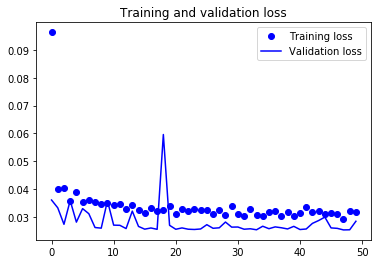

In [69]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [70]:
def data_from_generator(gen,steps):
    samp_imp = []
    samp_out = []
    for step in range(steps):
        samples, targets = next(gen)
        #preds = samples[:, -1, 1]
        #mae = np.mean(np.abs(preds - targets))
        #batch_maes.append(mae)
        samp_imp.extend(samples)
        samp_out.extend(targets)
    #print(np.mean(batch_maes))
    return samp_imp, samp_out

samp_imp, samp_out= data_from_generator(test_gen, test_steps)


In [71]:

#model=keras.models.load_model("modelANN_imputed_May30.h5")



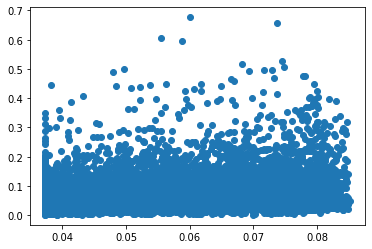

In [72]:

test_results=model.evaluate_generator(test_gen, steps=1)
pred_test=model.predict(np.array(samp_imp))
plt.plot(pred_test, samp_out,'o')

In [73]:
from sklearn import metrics
det_coeff= metrics.r2_score(samp_out,pred_test)
print(det_coeff)

-0.03177933878413031


In [74]:

test_results=model.evaluate_generator(test_gen)
pred_test=model.predict(np.array(samp_imp))
plt.plot(pred_test, samp_out,'o')

ValueError: `steps=None` is only valid for a generator based on the `keras.utils.Sequence` class. Please specify `steps` or use the `keras.utils.Sequence` class.

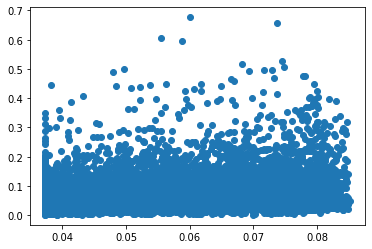

In [75]:

test_results=model.evaluate_generator(test_gen, steps=20)
pred_test=model.predict(np.array(samp_imp))
plt.plot(pred_test, samp_out,'o')

In [76]:
from sklearn import metrics
det_coeff= metrics.r2_score(samp_out,pred_test)
print(det_coeff)

-0.03177933878413031


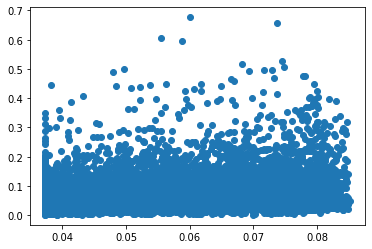

In [77]:

test_results=model.evaluate_generator(test_gen, steps=2)
pred_test=model.predict(np.array(samp_imp))
plt.plot(pred_test, samp_out,'o')

In [78]:
from sklearn import metrics
det_coeff= metrics.r2_score(samp_out,pred_test)
print(det_coeff)

-0.03177933878413031


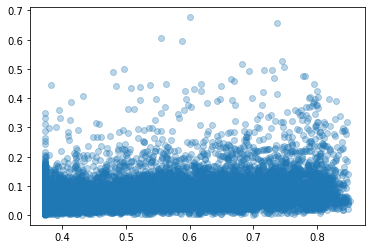

In [79]:
plt.plot(pred_test*10, samp_out,'o', alpha=0.3)

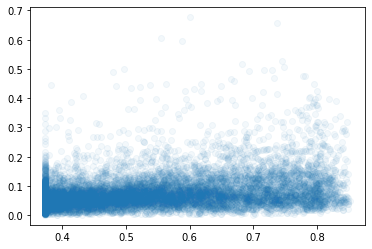

In [80]:
plt.plot(pred_test*10, samp_out,'o', alpha=0.05)

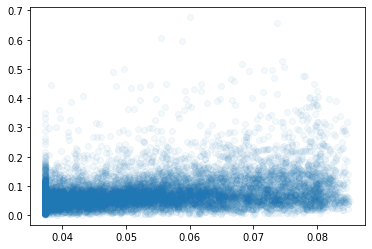

In [81]:
plt.plot(pred_test, samp_out,'o', alpha=0.05)

In [82]:
plt.plot(pred_test, samp_out,'o', alpha=0.05, [0,0.1], [0,0.1],'r--')

SyntaxError: positional argument follows keyword argument (<ipython-input-82-603b70c22648>, line 1)

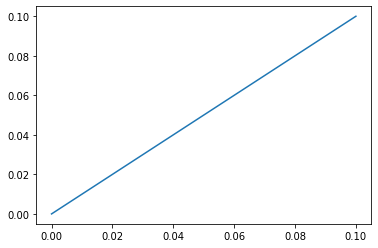

In [83]:
plt.plot([0,0.1],[0,0.1])

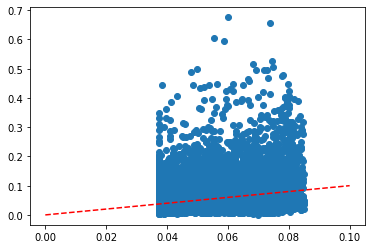

In [84]:
plt.plot(pred_test, samp_out,'o', [0,0.1], [0,0.1],'r--')

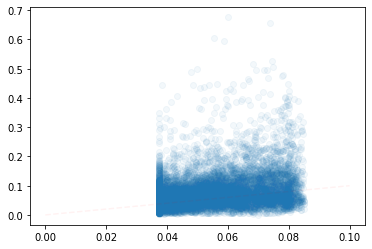

In [85]:
plt.plot(pred_test, samp_out,'o', [0,0.1], [0,0.1],'r--',alpha=0.05)

In [86]:
#pylint: disable=import-error
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, df2.shape[-1])))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae', metrics=['mean_squared_error'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=50,
                              epochs=50,
                              validation_data=val_gen,
                              validation_steps=val_steps)


Epoch 1/50
50/50 [==============================] - 1s 24ms/step - loss: 0.0597 - mean_squared_error: 0.0105 - val_loss: 0.0283 - val_mean_squared_error: 0.0019
Epoch 2/50
50/50 [==============================] - 1s 13ms/step - loss: 0.0398 - mean_squared_error: 0.0037 - val_loss: 0.0306 - val_mean_squared_error: 0.0021
Epoch 3/50
50/50 [==============================] - 1s 13ms/step - loss: 0.0352 - mean_squared_error: 0.0028 - val_loss: 0.0272 - val_mean_squared_error: 0.0015
Epoch 4/50
50/50 [==============================] - 1s 12ms/step - loss: 0.0340 - mean_squared_error: 0.0029 - val_loss: 0.0306 - val_mean_squared_error: 0.0021
Epoch 5/50
50/50 [==============================] - 1s 12ms/step - loss: 0.0326 - mean_squared_error: 0.0026 - val_loss: 0.0335 - val_mean_squared_error: 0.0018
Epoch 6/50
50/50 [==============================] - 1s 12ms/step - loss: 0.0332 - mean_squared_error: 0.0032 - val_loss: 0.0280 - val_mean_squared_error: 0.0018
Epoch 7/50
50/50 [================

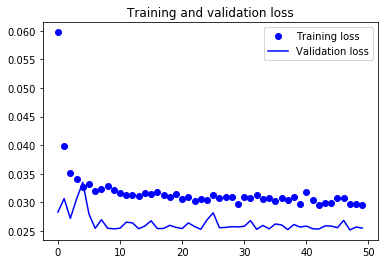

In [87]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [88]:
def data_from_generator(gen,steps):
    samp_imp = []
    samp_out = []
    for step in range(steps):
        samples, targets = next(gen)
        #preds = samples[:, -1, 1]
        #mae = np.mean(np.abs(preds - targets))
        #batch_maes.append(mae)
        samp_imp.extend(samples)
        samp_out.extend(targets)
    #print(np.mean(batch_maes))
    return samp_imp, samp_out

samp_imp, samp_out= data_from_generator(test_gen, test_steps)


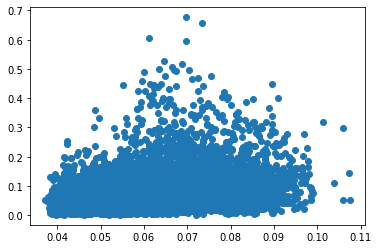

In [89]:

test_results=model.evaluate_generator(test_gen, steps=2)
pred_test=model.predict(np.array(samp_imp))

#Coefficient of determination (r^2)
plt.plot(pred_test, samp_out,'o')

In [90]:
from sklearn import metrics
det_coeff= metrics.r2_score(samp_out,pred_test)
print(det_coeff)

0.05174717559576014


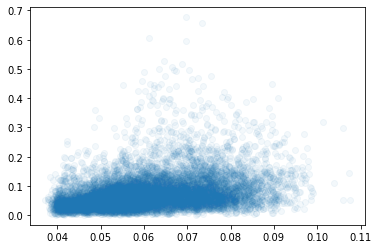

In [91]:

test_results=model.evaluate_generator(test_gen, steps=2)
pred_test=model.predict(np.array(samp_imp))

#Coefficient of determination (r^2)
plt.plot(pred_test, samp_out,'o', alpha=0.05)

In [92]:
#pylint: disable=no-name-in-module
from tensorflow import keras
import numpy as np
import pandas as pd


In [93]:
def data_from_generator(gen,steps):
    samp_imp = []
    samp_out = []
    for step in range(steps):
        samples, targets = next(gen)
        #preds = samples[:, -1, 1]
        #mae = np.mean(np.abs(preds - targets))
        #batch_maes.append(mae)
        samp_imp.extend(samples)
        samp_out.extend(targets)
    #print(np.mean(batch_maes))
    return samp_imp, samp_out

samp_imp, samp_out= data_from_generator(test_gen, test_steps)


In [94]:

#model=keras.models.load_model("modelANN_imputed_May30.h5")



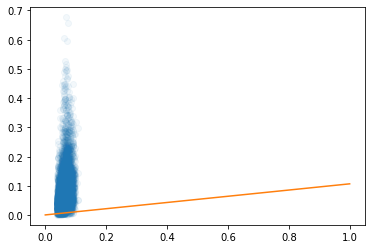

In [95]:

test_results=model.evaluate_generator(test_gen, steps=2)
pred_test=model.predict(np.array(samp_imp))

#Coefficient of determination (r^2)
plt.plot(pred_test, samp_out,'o', alpha=0.05)
plt.plot([min(min(pred_test),min(samp_out)),min(max(pred_test),max(samp_out))])

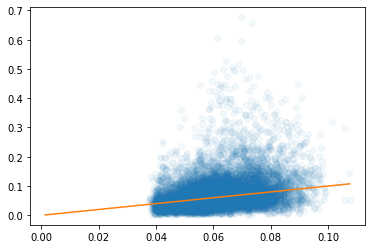

In [96]:

test_results=model.evaluate_generator(test_gen, steps=2)
pred_test=model.predict(np.array(samp_imp))

#Coefficient of determination (r^2)
plt.plot(pred_test, samp_out,'o', alpha=0.05)
plt.plot([min(min(pred_test),min(samp_out)),
        min(max(pred_test),max(samp_out))],
        [min(min(pred_test),min(samp_out)),
        min(max(pred_test),max(samp_out))])

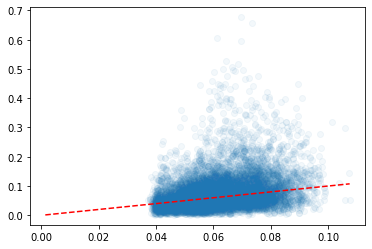

In [97]:

test_results=model.evaluate_generator(test_gen, steps=2)
pred_test=model.predict(np.array(samp_imp))

#Coefficient of determination (r^2)
plt.plot(pred_test, samp_out,'o', alpha=0.05)
plt.plot([min(min(pred_test),min(samp_out)),
        min(max(pred_test),max(samp_out))],
        [min(min(pred_test),min(samp_out)),
        min(max(pred_test),max(samp_out))],
        'r--')

In [98]:
#pylint: disable=import-error
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, df2.shape[-1])))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae', metrics=['mean_squared_error'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=50,
                              epochs=50,
                              validation_data=val_gen,
                              validation_steps=val_steps)


Epoch 1/50
50/50 [==============================] - 1s 23ms/step - loss: 0.0539 - mean_squared_error: 0.0098 - val_loss: 0.0261 - val_mean_squared_error: 0.0016
Epoch 2/50
50/50 [==============================] - 1s 13ms/step - loss: 0.0355 - mean_squared_error: 0.0029 - val_loss: 0.0260 - val_mean_squared_error: 0.0015
Epoch 3/50
50/50 [==============================] - 1s 12ms/step - loss: 0.0335 - mean_squared_error: 0.0028 - val_loss: 0.0299 - val_mean_squared_error: 0.0016
Epoch 4/50
50/50 [==============================] - 1s 13ms/step - loss: 0.0319 - mean_squared_error: 0.0025 - val_loss: 0.0256 - val_mean_squared_error: 0.0015
Epoch 5/50
50/50 [==============================] - 1s 12ms/step - loss: 0.0333 - mean_squared_error: 0.0029 - val_loss: 0.0256 - val_mean_squared_error: 0.0015
Epoch 6/50
50/50 [==============================] - 1s 12ms/step - loss: 0.0324 - mean_squared_error: 0.0028 - val_loss: 0.0256 - val_mean_squared_error: 0.0015
Epoch 7/50
50/50 [================

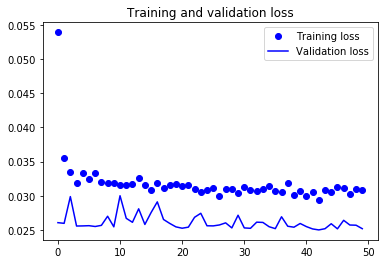

In [99]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [100]:
#pylint: disable=import-error
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, df2.shape[-1])))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae', metrics=['mean_squared_error'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=50,
                              epochs=50,
                              validation_data=val_gen,
                              validation_steps=val_steps)


Epoch 1/50
50/50 [==============================] - 1s 24ms/step - loss: 0.0674 - mean_squared_error: 0.0139 - val_loss: 0.0309 - val_mean_squared_error: 0.0017
Epoch 2/50
50/50 [==============================] - 1s 14ms/step - loss: 0.0386 - mean_squared_error: 0.0030 - val_loss: 0.0271 - val_mean_squared_error: 0.0015
Epoch 3/50
50/50 [==============================] - 1s 13ms/step - loss: 0.0350 - mean_squared_error: 0.0028 - val_loss: 0.0270 - val_mean_squared_error: 0.0018
Epoch 4/50
50/50 [==============================] - 1s 13ms/step - loss: 0.0340 - mean_squared_error: 0.0028 - val_loss: 0.0262 - val_mean_squared_error: 0.0015
Epoch 5/50
50/50 [==============================] - 1s 13ms/step - loss: 0.0331 - mean_squared_error: 0.0028 - val_loss: 0.0260 - val_mean_squared_error: 0.0015
Epoch 6/50
50/50 [==============================] - 1s 13ms/step - loss: 0.0329 - mean_squared_error: 0.0029 - val_loss: 0.0299 - val_mean_squared_error: 0.0016
Epoch 7/50
50/50 [================

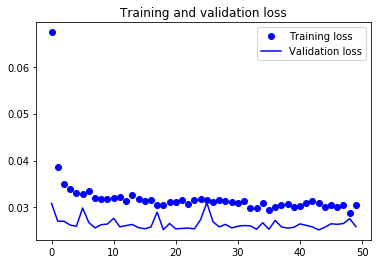

In [101]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [102]:
#pylint: disable=import-error
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, df2.shape[-1])))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae', metrics=['mean_squared_error'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=50,
                              epochs=50,
                              validation_data=val_gen,
                              validation_steps=val_steps)


Epoch 1/50
50/50 [==============================] - 1s 25ms/step - loss: 0.0553 - mean_squared_error: 0.0066 - val_loss: 0.0352 - val_mean_squared_error: 0.0019
Epoch 2/50
50/50 [==============================] - 1s 13ms/step - loss: 0.0384 - mean_squared_error: 0.0032 - val_loss: 0.0350 - val_mean_squared_error: 0.0019
Epoch 3/50
50/50 [==============================] - 1s 15ms/step - loss: 0.0369 - mean_squared_error: 0.0032 - val_loss: 0.0310 - val_mean_squared_error: 0.0022
Epoch 4/50
50/50 [==============================] - 1s 12ms/step - loss: 0.0355 - mean_squared_error: 0.0031 - val_loss: 0.0262 - val_mean_squared_error: 0.0016
Epoch 5/50
50/50 [==============================] - 1s 13ms/step - loss: 0.0338 - mean_squared_error: 0.0027 - val_loss: 0.0258 - val_mean_squared_error: 0.0016
Epoch 6/50
50/50 [==============================] - 1s 13ms/step - loss: 0.0336 - mean_squared_error: 0.0027 - val_loss: 0.0266 - val_mean_squared_error: 0.0017
Epoch 7/50
50/50 [================

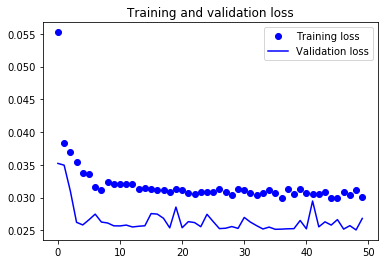

In [103]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [104]:
def data_from_generator(gen,steps):
    samp_imp = []
    samp_out = []
    for step in range(steps):
        samples, targets = next(gen)
        #preds = samples[:, -1, 1]
        #mae = np.mean(np.abs(preds - targets))
        #batch_maes.append(mae)
        samp_imp.extend(samples)
        samp_out.extend(targets)
    #print(np.mean(batch_maes))
    return samp_imp, samp_out

samp_imp, samp_out= data_from_generator(test_gen, test_steps)


In [105]:

#model=keras.models.load_model("modelANN_imputed_May30.h5")



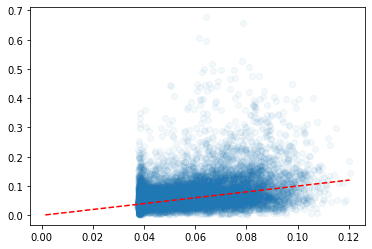

In [106]:

test_results=model.evaluate_generator(test_gen, steps=2)
pred_test=model.predict(np.array(samp_imp))

#Coefficient of determination (r^2)
plt.plot(pred_test, samp_out,'o', alpha=0.05)
plt.plot([min(min(pred_test),min(samp_out)),
        min(max(pred_test),max(samp_out))],
        [min(min(pred_test),min(samp_out)),
        min(max(pred_test),max(samp_out))],
        'r--')

In [107]:
from sklearn import metrics
det_coeff= metrics.r2_score(samp_out,pred_test)
print(det_coeff)

0.050452264757846366


In [108]:
# concentration in a delay.
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            #Here my targets could be O3(4),PM10(5),PM2.5(6)
            targets[j] = data[rows[j] + delay][6]
        yield samples, targets

In [109]:
lookback = 72
step = 1
delay = 24
batch_size = 128

train_gen = generator(df2,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=35000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(df2,
                    lookback=lookback,
                    delay=delay,
                    min_index=35001,
                    max_index=40000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(df2,
                     lookback=lookback,
                     delay=delay,
                     min_index=40001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)


In [110]:

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (40000 - 35001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(df2) - 40001 - lookback) // batch_size


In [111]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()


0.01918495904145522


In [112]:
#pylint: disable=import-error
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, df2.shape[-1])))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae', metrics=['mean_squared_error'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=50,
                              epochs=50,
                              validation_data=val_gen,
                              validation_steps=val_steps)


Epoch 1/50
50/50 [==============================] - 1s 24ms/step - loss: 0.0315 - mean_squared_error: 0.0045 - val_loss: 0.0143 - val_mean_squared_error: 3.3572e-04
Epoch 2/50
50/50 [==============================] - 1s 12ms/step - loss: 0.0172 - mean_squared_error: 6.2305e-04 - val_loss: 0.0106 - val_mean_squared_error: 1.8207e-04
Epoch 3/50
50/50 [==============================] - 1s 12ms/step - loss: 0.0141 - mean_squared_error: 5.0534e-04 - val_loss: 0.0115 - val_mean_squared_error: 2.1761e-04
Epoch 4/50
50/50 [==============================] - 1s 12ms/step - loss: 0.0123 - mean_squared_error: 4.1947e-04 - val_loss: 0.0112 - val_mean_squared_error: 1.9744e-04
Epoch 5/50
50/50 [==============================] - 1s 12ms/step - loss: 0.0120 - mean_squared_error: 3.7579e-04 - val_loss: 0.0119 - val_mean_squared_error: 2.2769e-04
Epoch 6/50
50/50 [==============================] - 1s 12ms/step - loss: 0.0119 - mean_squared_error: 5.5258e-04 - val_loss: 0.0111 - val_mean_squared_error: 2

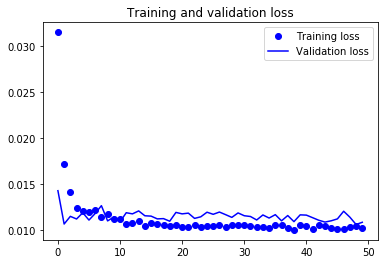

In [113]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [114]:
#pylint: disable=import-error
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, df2.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae', metrics=['mean_squared_error'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=50,
                              epochs=50,
                              validation_data=val_gen,
                              validation_steps=val_steps)


Epoch 1/50
50/50 [==============================] - 1s 27ms/step - loss: 0.0232 - mean_squared_error: 0.0013 - val_loss: 0.0108 - val_mean_squared_error: 1.9299e-04
Epoch 2/50
50/50 [==============================] - 1s 13ms/step - loss: 0.0132 - mean_squared_error: 4.8783e-04 - val_loss: 0.0123 - val_mean_squared_error: 2.4365e-04
Epoch 3/50
50/50 [==============================] - 1s 14ms/step - loss: 0.0116 - mean_squared_error: 3.1371e-04 - val_loss: 0.0125 - val_mean_squared_error: 2.5782e-04
Epoch 4/50
50/50 [==============================] - 1s 13ms/step - loss: 0.0108 - mean_squared_error: 4.6805e-04 - val_loss: 0.0108 - val_mean_squared_error: 1.7976e-04
Epoch 5/50
50/50 [==============================] - 1s 13ms/step - loss: 0.0107 - mean_squared_error: 2.9177e-04 - val_loss: 0.0114 - val_mean_squared_error: 2.0947e-04
Epoch 6/50
50/50 [==============================] - 1s 13ms/step - loss: 0.0107 - mean_squared_error: 4.0448e-04 - val_loss: 0.0121 - val_mean_squared_error: 2

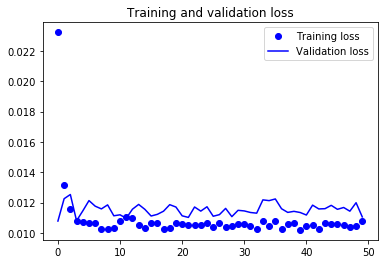

In [115]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [116]:
#pylint: disable=import-error
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, df2.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
#model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae', metrics=['mean_squared_error'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=50,
                              epochs=50,
                              validation_data=val_gen,
                              validation_steps=val_steps)


Epoch 1/50
50/50 [==============================] - 1s 26ms/step - loss: 0.0476 - mean_squared_error: 0.0042 - val_loss: 0.0219 - val_mean_squared_error: 6.4102e-04
Epoch 2/50
50/50 [==============================] - 1s 12ms/step - loss: 0.0192 - mean_squared_error: 5.9540e-04 - val_loss: 0.0112 - val_mean_squared_error: 1.9016e-04
Epoch 3/50
50/50 [==============================] - 1s 12ms/step - loss: 0.0131 - mean_squared_error: 4.7859e-04 - val_loss: 0.0115 - val_mean_squared_error: 2.1605e-04
Epoch 4/50
50/50 [==============================] - 1s 13ms/step - loss: 0.0119 - mean_squared_error: 3.2043e-04 - val_loss: 0.0116 - val_mean_squared_error: 2.0840e-04
Epoch 5/50
50/50 [==============================] - 1s 12ms/step - loss: 0.0117 - mean_squared_error: 4.9628e-04 - val_loss: 0.0139 - val_mean_squared_error: 3.1887e-04
Epoch 6/50
50/50 [==============================] - 1s 12ms/step - loss: 0.0109 - mean_squared_error: 2.7978e-04 - val_loss: 0.0108 - val_mean_squared_error: 1

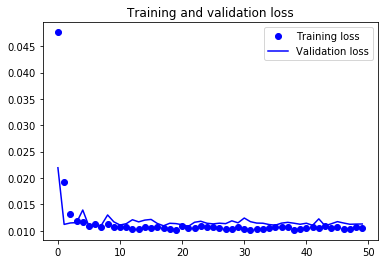

In [117]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [118]:
#pylint: disable=import-error
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, df2.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
#model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae', metrics=['mean_squared_error'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=50,
                              epochs=50,
                              validation_data=val_gen,
                              validation_steps=val_steps)


Epoch 1/50
50/50 [==============================] - 1s 28ms/step - loss: 0.0419 - mean_squared_error: 0.0033 - val_loss: 0.0123 - val_mean_squared_error: 2.4940e-04
Epoch 2/50
50/50 [==============================] - 1s 13ms/step - loss: 0.0150 - mean_squared_error: 4.4016e-04 - val_loss: 0.0111 - val_mean_squared_error: 1.8996e-04
Epoch 3/50
50/50 [==============================] - 1s 13ms/step - loss: 0.0139 - mean_squared_error: 4.1706e-04 - val_loss: 0.0114 - val_mean_squared_error: 1.9879e-04
Epoch 4/50
50/50 [==============================] - 1s 13ms/step - loss: 0.0131 - mean_squared_error: 3.5170e-04 - val_loss: 0.0177 - val_mean_squared_error: 4.8351e-04
Epoch 5/50
50/50 [==============================] - 1s 13ms/step - loss: 0.0123 - mean_squared_error: 3.7299e-04 - val_loss: 0.0120 - val_mean_squared_error: 2.3262e-04
Epoch 6/50
50/50 [==============================] - 1s 14ms/step - loss: 0.0117 - mean_squared_error: 5.8610e-04 - val_loss: 0.0121 - val_mean_squared_error: 2

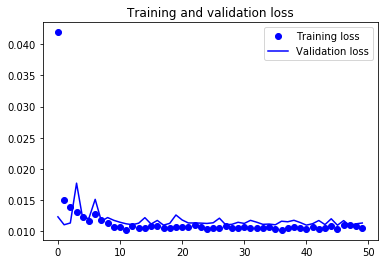

In [119]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [120]:
#pylint: disable=import-error
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, df2.shape[-1])))
model.add(layers.Dense(32, activation='sigmoid'))
#model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='sigmoid'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae', metrics=['mean_squared_error'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=50,
                              epochs=50,
                              validation_data=val_gen,
                              validation_steps=val_steps)


Epoch 1/50
50/50 [==============================] - 1s 28ms/step - loss: 0.0526 - mean_squared_error: 0.0042 - val_loss: 0.0593 - val_mean_squared_error: 0.0037
Epoch 2/50
50/50 [==============================] - 1s 14ms/step - loss: 0.0405 - mean_squared_error: 0.0024 - val_loss: 0.0545 - val_mean_squared_error: 0.0031
Epoch 3/50
50/50 [==============================] - 1s 13ms/step - loss: 0.0381 - mean_squared_error: 0.0022 - val_loss: 0.0516 - val_mean_squared_error: 0.0028
Epoch 4/50
50/50 [==============================] - 1s 13ms/step - loss: 0.0356 - mean_squared_error: 0.0017 - val_loss: 0.0429 - val_mean_squared_error: 0.0020
Epoch 5/50
50/50 [==============================] - 1s 13ms/step - loss: 0.0339 - mean_squared_error: 0.0016 - val_loss: 0.0398 - val_mean_squared_error: 0.0017
Epoch 6/50
50/50 [==============================] - 1s 13ms/step - loss: 0.0310 - mean_squared_error: 0.0013 - val_loss: 0.0397 - val_mean_squared_error: 0.0017
Epoch 7/50
50/50 [================

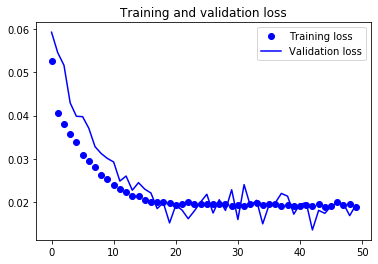

In [121]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [122]:
def data_from_generator(gen,steps):
    samp_imp = []
    samp_out = []
    for step in range(steps):
        samples, targets = next(gen)
        #preds = samples[:, -1, 1]
        #mae = np.mean(np.abs(preds - targets))
        #batch_maes.append(mae)
        samp_imp.extend(samples)
        samp_out.extend(targets)
    #print(np.mean(batch_maes))
    return samp_imp, samp_out

samp_imp, samp_out= data_from_generator(test_gen, test_steps)


In [123]:

#model=keras.models.load_model("modelANN_imputed_May30.h5")



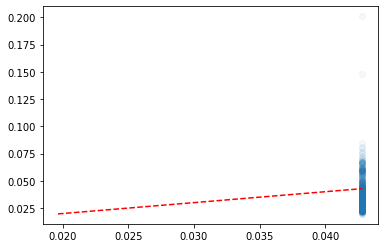

In [124]:

test_results=model.evaluate_generator(test_gen, steps=2)
pred_test=model.predict(np.array(samp_imp))

#Coefficient of determination (r^2)
plt.plot(pred_test, samp_out,'o', alpha=0.05)
plt.plot([min(min(pred_test),min(samp_out)),
        min(max(pred_test),max(samp_out))],
        [min(min(pred_test),min(samp_out)),
        min(max(pred_test),max(samp_out))],
        'r--')

In [125]:
from sklearn import metrics
det_coeff= metrics.r2_score(samp_out,pred_test)
print(det_coeff)

-5.676072011795608


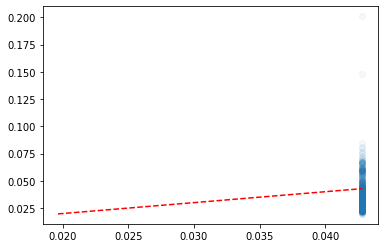

In [126]:

test_results=model.evaluate_generator(test_gen, steps=2)
pred_test=model.predict(np.array(samp_imp))

#Coefficient of determination (r^2)
plt.plot(pred_test, samp_out,'o', alpha=0.05)
plt.plot([min(min(pred_test),min(samp_out)),
        min(max(pred_test),max(samp_out))],
        [min(min(pred_test),min(samp_out)),
        min(max(pred_test),max(samp_out))],
        'r--')

In [127]:

test_results=model.evaluate_generator(test_gen, steps=2)
pred_test=model.predict(np.array(samp_imp))

#Coefficient of determination (r^2)
plt.plot(pred_test, samp_out,'o', alpha=0.05)
#plt.plot([min(min(pred_test),min(samp_out)),
        min(max(pred_test),max(samp_out))],
        [min(min(pred_test),min(samp_out)),
        min(max(pred_test),max(samp_out))],
        'r--')

IndentationError: unexpected indent (<ipython-input-127-be23c5c56a7e>, line 8)

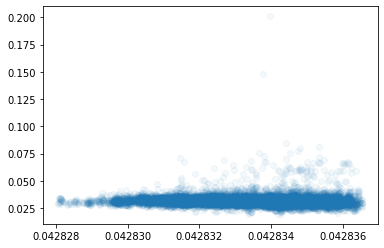

In [128]:

test_results=model.evaluate_generator(test_gen, steps=2)
pred_test=model.predict(np.array(samp_imp))

#Coefficient of determination (r^2)
plt.plot(pred_test, samp_out,'o', alpha=0.05)


In [129]:
#pylint: disable=import-error
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, df2.shape[-1])))
model.add(layers.Dense(32, activation='sigmoid'))
#model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='ReLU'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mean_squared_error', metrics=['mean_squared_error'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=50,
                              epochs=50,
                              validation_data=val_gen,
                              validation_steps=val_steps)


ValueError: Unknown activation function:ReLU

In [130]:
#pylint: disable=import-error
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, df2.shape[-1])))
model.add(layers.Dense(32, activation='sigmoid'))
#model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mean_squared_error', metrics=['mean_squared_error'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=50,
                              epochs=50,
                              validation_data=val_gen,
                              validation_steps=val_steps)


Epoch 1/50
50/50 [==============================] - 2s 36ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 2/50
50/50 [==============================] - 1s 13ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 3/50
50/50 [==============================] - 1s 13ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 4/50
50/50 [==============================] - 1s 13ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 5/50
50/50 [==============================] - 1s 13ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 8.2162e-04 - val_mean_squared_error: 8.2162e-04
Epoch 6/50
50/50 [==============================] - 1s 13ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 7/50
50/50 [========

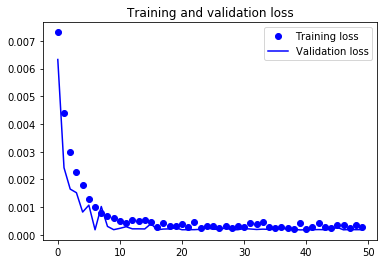

In [131]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [132]:
def data_from_generator(gen,steps):
    samp_imp = []
    samp_out = []
    for step in range(steps):
        samples, targets = next(gen)
        #preds = samples[:, -1, 1]
        #mae = np.mean(np.abs(preds - targets))
        #batch_maes.append(mae)
        samp_imp.extend(samples)
        samp_out.extend(targets)
    #print(np.mean(batch_maes))
    return samp_imp, samp_out

samp_imp, samp_out= data_from_generator(test_gen, test_steps)


In [133]:

#model=keras.models.load_model("modelANN_imputed_May30.h5")



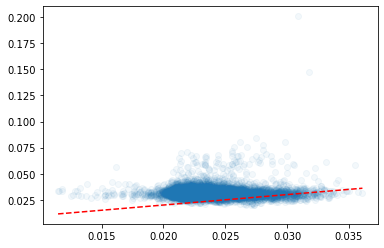

In [134]:

test_results=model.evaluate_generator(test_gen, steps=2)
pred_test=model.predict(np.array(samp_imp))

#Coefficient of determination (r^2)
plt.plot(pred_test, samp_out,'o', alpha=0.05)
plt.plot([min(min(pred_test),min(samp_out)),
        min(max(pred_test),max(samp_out))],
        [min(min(pred_test),min(samp_out)),
        min(max(pred_test),max(samp_out))],
        'r--')

In [135]:
from sklearn import metrics
det_coeff= metrics.r2_score(samp_out,pred_test)
print(det_coeff)

-3.899315034945433


In [136]:
# concentration in a delay.
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            #Here my targets could be O3(4),PM10(5),PM2.5(6)
            targets[j] = data[rows[j] + delay][5]
        yield samples, targets

In [137]:
lookback = 72
step = 1
delay = 24
batch_size = 128

train_gen = generator(df2,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=35000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(df2,
                    lookback=lookback,
                    delay=delay,
                    min_index=35001,
                    max_index=40000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(df2,
                     lookback=lookback,
                     delay=delay,
                     min_index=40001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)


In [138]:

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (40000 - 35001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(df2) - 40001 - lookback) // batch_size


In [139]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()


0.061107793651198596


In [140]:
#pylint: disable=import-error
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, df2.shape[-1])))
model.add(layers.Dense(32, activation='sigmoid'))
#model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mean_squared_error', metrics=['mean_squared_error'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=50,
                              epochs=50,
                              validation_data=val_gen,
                              validation_steps=val_steps)


Epoch 1/50
50/50 [==============================] - 1s 28ms/step - loss: 0.0211 - mean_squared_error: 0.0211 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 2/50
50/50 [==============================] - 1s 13ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 3/50
50/50 [==============================] - 1s 12ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 4/50
50/50 [==============================] - 1s 12ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 5/50
50/50 [==============================] - 1s 12ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 6/50
50/50 [==============================] - 1s 12ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 7/50
50/50 [================

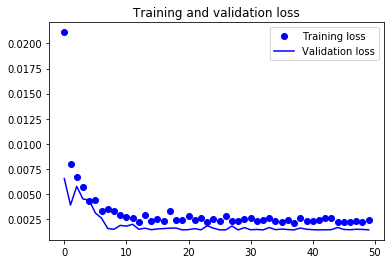

In [141]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [142]:
def data_from_generator(gen,steps):
    samp_imp = []
    samp_out = []
    for step in range(steps):
        samples, targets = next(gen)
        #preds = samples[:, -1, 1]
        #mae = np.mean(np.abs(preds - targets))
        #batch_maes.append(mae)
        samp_imp.extend(samples)
        samp_out.extend(targets)
    #print(np.mean(batch_maes))
    return samp_imp, samp_out

samp_imp, samp_out= data_from_generator(test_gen, test_steps)


In [143]:

#model=keras.models.load_model("modelANN_imputed_May30.h5")



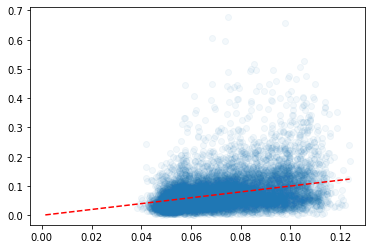

In [144]:

test_results=model.evaluate_generator(test_gen, steps=2)
pred_test=model.predict(np.array(samp_imp))

#Coefficient of determination (r^2)
plt.plot(pred_test, samp_out,'o', alpha=0.05)
plt.plot([min(min(pred_test),min(samp_out)),
        min(max(pred_test),max(samp_out))],
        [min(min(pred_test),min(samp_out)),
        min(max(pred_test),max(samp_out))],
        'r--')

In [145]:
from sklearn import metrics
det_coeff= metrics.r2_score(samp_out,pred_test)
print(det_coeff)

0.14335011671761333


In [146]:
#pylint: disable=import-error
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, df2.shape[-1])))
model.add(layers.Dense(32, activation='sigmoid'))
#model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='linear'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mean_squared_error', metrics=['mean_squared_error'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=50,
                              epochs=50,
                              validation_data=val_gen,
                              validation_steps=val_steps)


Epoch 1/50
50/50 [==============================] - 2s 31ms/step - loss: 0.0424 - mean_squared_error: 0.0424 - val_loss: 0.0212 - val_mean_squared_error: 0.0212
Epoch 2/50
50/50 [==============================] - 1s 13ms/step - loss: 0.0164 - mean_squared_error: 0.0164 - val_loss: 0.0134 - val_mean_squared_error: 0.0134
Epoch 3/50
50/50 [==============================] - 1s 13ms/step - loss: 0.0142 - mean_squared_error: 0.0142 - val_loss: 0.0130 - val_mean_squared_error: 0.0130
Epoch 4/50
50/50 [==============================] - 1s 14ms/step - loss: 0.0106 - mean_squared_error: 0.0106 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 5/50
50/50 [==============================] - 1s 13ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 6/50
50/50 [==============================] - 1s 13ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 7/50
50/50 [================

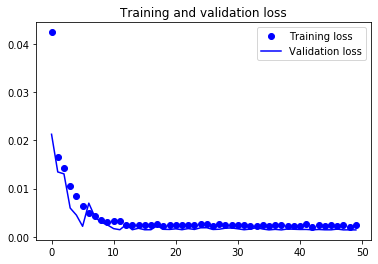

In [147]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [148]:
def data_from_generator(gen,steps):
    samp_imp = []
    samp_out = []
    for step in range(steps):
        samples, targets = next(gen)
        #preds = samples[:, -1, 1]
        #mae = np.mean(np.abs(preds - targets))
        #batch_maes.append(mae)
        samp_imp.extend(samples)
        samp_out.extend(targets)
    #print(np.mean(batch_maes))
    return samp_imp, samp_out

samp_imp, samp_out= data_from_generator(test_gen, test_steps)


In [149]:

#model=keras.models.load_model("modelANN_imputed_May30.h5")



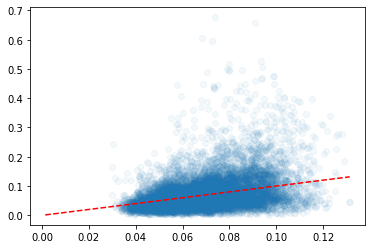

In [150]:

test_results=model.evaluate_generator(test_gen, steps=2)
pred_test=model.predict(np.array(samp_imp))

#Coefficient of determination (r^2)
plt.plot(pred_test, samp_out,'o', alpha=0.05)
plt.plot([min(min(pred_test),min(samp_out)),
        min(max(pred_test),max(samp_out))],
        [min(min(pred_test),min(samp_out)),
        min(max(pred_test),max(samp_out))],
        'r--')

In [151]:
from sklearn import metrics
det_coeff= metrics.r2_score(samp_out,pred_test)
print(det_coeff)

0.13793273918719762


In [152]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='linear'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mean_squared_error', metrics=['mean_squared_error'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=50,
                              epochs=50,
                              validation_data=val_gen,
                              validation_steps=val_steps)


0.06110779365119858
Epoch 1/50
50/50 [==============================] - 2s 32ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 2/50
50/50 [==============================] - 1s 13ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 3/50
50/50 [==============================] - 1s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 4/50
50/50 [==============================] - 1s 13ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 5/50
50/50 [==============================] - 1s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 6/50
50/50 [==============================] - 1s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 7/50
50/

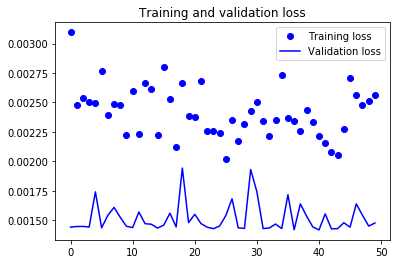

In [153]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [154]:
#pylint: disable=import-error
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, df2.shape[-1])))
model.add(layers.Dense(32, activation='sigmoid'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='linear'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mean_squared_error', metrics=['mean_squared_error'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=50,
                              epochs=50,
                              validation_data=val_gen,
                              validation_steps=val_steps)


Epoch 1/50
50/50 [==============================] - 2s 33ms/step - loss: 0.0217 - mean_squared_error: 0.0217 - val_loss: 0.0142 - val_mean_squared_error: 0.0142
Epoch 2/50
50/50 [==============================] - 1s 13ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 3/50
50/50 [==============================] - 1s 14ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 4/50
50/50 [==============================] - 1s 12ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 5/50
50/50 [==============================] - 1s 12ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 6/50
50/50 [==============================] - 1s 13ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 7/50
50/50 [================

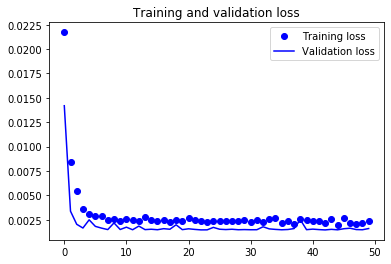

In [155]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [156]:
def data_from_generator(gen,steps):
    samp_imp = []
    samp_out = []
    for step in range(steps):
        samples, targets = next(gen)
        #preds = samples[:, -1, 1]
        #mae = np.mean(np.abs(preds - targets))
        #batch_maes.append(mae)
        samp_imp.extend(samples)
        samp_out.extend(targets)
    #print(np.mean(batch_maes))
    return samp_imp, samp_out

samp_imp, samp_out= data_from_generator(test_gen, test_steps)


In [157]:

#model=keras.models.load_model("modelANN_imputed_May30.h5")



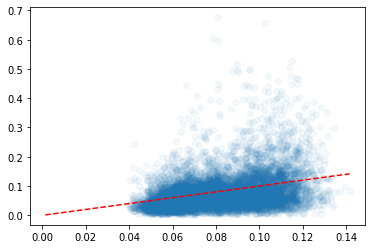

In [158]:

test_results=model.evaluate_generator(test_gen, steps=2)
pred_test=model.predict(np.array(samp_imp))

#Coefficient of determination (r^2)
plt.plot(pred_test, samp_out,'o', alpha=0.05)
plt.plot([min(min(pred_test),min(samp_out)),
        min(max(pred_test),max(samp_out))],
        [min(min(pred_test),min(samp_out)),
        min(max(pred_test),max(samp_out))],
        'r--')

In [159]:
from sklearn import metrics
det_coeff= metrics.r2_score(samp_out,pred_test)
print(det_coeff)

0.1322807954256069
